In [1]:
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import cv2

/home/neru/M5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
#load dataset
#annotations_path = "/export/home/group05/annotations/instances_val2017.json"
#database_path = "/export/home/group05/val2017/"

annotations_path = "./annotations/instances_val2017.json"
annotations_train_path = "./annotations/instances_train2017.json"
database_path = "./val2017/"
coco_annotation=COCO(annotations_path)

loading annotations into memory...
Done (t=2.99s)
creating index...
index created!


In [5]:
def load_image_and_annotations(img_filename, database_path):
    img = cv2.imread(database_path+img_filename)
    img_id = int(img_filename.split('.')[0])
    info = coco_annotation.loadImgs([img_id])[0]
    ann_ids = coco_annotation.getAnnIds(imgIds=[img_id])
    anns = coco_annotation.loadAnns(ann_ids)
    masks = [coco_annotation.annToMask(ann) for ann in anns]

    print("Random image annotations" ,anns)
    return img, info, masks


def pad_images(imgs, new_image_height, new_image_width):
    
    color = (0, 0, 0)
    result_imgs = []
    
    for img in imgs:
        if len(img.shape) == 3:
            old_image_height, old_image_width, channels = img.shape

            result = np.full((new_image_height, new_image_width, channels), color, dtype=np.uint8)
        elif len(img.shape) == 2:
            old_image_height, old_image_width = img.shape
            result = np.full((new_image_height, new_image_width), 0, dtype=np.uint8)

        print("NEW ", new_image_height, "W ", new_image_width)
        print("OLD ", old_image_height, "W ", old_image_width)

        # compute center offset
        x_center = round((new_image_width - old_image_width) / 2)
        y_center = round((new_image_height - old_image_height) / 2)

        if old_image_height > new_image_height:
            img = img[round((old_image_height - new_image_height) / 2):-round((old_image_height - new_image_height) / 2), :]
            old_image_height = new_image_height
        if old_image_width > new_image_width:
            img = img[:, round((old_image_width - new_image_width) / 2):-round((old_image_width - new_image_width) / 2)]
            old_image_width = new_image_width

        print("OLD AFTER CROP ", img.shape[0], "W ", img.shape[1])

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,             x_center:x_center+old_image_width] = img
        
        result_imgs.append(result)
        
    return result_imgs


def transplant_images(image_1, image_2, image_2_mask):
    image_1_copy = image_1.copy() 
    image_1_copy[np.where(image_2_mask == 1)] = image_2[np.where(image_2_mask == 1)]
    rows, cols = np.where(image_2_mask == 1)
    image_1_copy[rows, cols, :] = image_2[rows, cols, :]
    return image_1_copy


def apply_transformation(img_list, tx, ty, angle):
    warped_img_list = []
    for img in img_list:
        print(img.shape)  # add this line to check the shape of img
        M = cv2.getRotationMatrix2D((ty, tx), angle, 1)
        warped_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        warped_img_list.append(warped_img)
    print('warped_img_list', len(warped_img_list))
    return warped_img_list


def predict(predictor, img):
    outputs = predictor(img)
    output_predictions = outputs["instances"].pred_classes
    print(output_predictions)
    print(outputs["instances"].pred_boxes)

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image= out.get_image()
    return output_image, output_predictions


def compute_box_iou(box1, box2):
    # Calculate the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # If the intersection is empty, return 0.0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the areas of each bounding box and the intersection
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the union of the bounding boxes
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area

    return iou


def compute_piou(image1, image2, predictor):
    # Get the predicted instance segmentation masks and classes for both images
    outputs1 = predictor(image1)
    outputs2 = predictor(image2)
    masks1 = outputs1["instances"].pred_masks.to("cpu").numpy()
    masks2 = outputs2["instances"].pred_masks.to("cpu").numpy()
    classes1 = outputs1["instances"].pred_classes.to("cpu").numpy()
    classes2 = outputs2["instances"].pred_classes.to("cpu").numpy()

    anns1 = outputs1["instances"].to("cpu").get_fields()["pred_boxes"].tensor.numpy()
    anns2 = outputs2["instances"].to("cpu").get_fields()["pred_boxes"].tensor.numpy()

    print(f"Number of annotations for image 1: {len(anns1)}")
    # for i, (ann1, cls1) in enumerate(zip(anns1, classes1)):
    #     print(f"Annotation {i+1} for object: {ann1}, Class: {cls1}")
        
    print(f"Number of annotations for image 2: {len(anns2)}")
    # for i, (ann2, cls2) in enumerate(zip(anns2, classes2)):
    #     print(f"Annotation {i+1} for object: {ann2}, Class: {cls2}")

    pious_list = []

    for i, (ann1, cls1) in enumerate(zip(anns1, classes1)):
        max_iou = 0
        for j, (ann2, cls2) in enumerate(zip(anns2, classes2)):
            iou = compute_box_iou(ann1, ann2)
            if iou > max_iou:
                max_iou = iou
                max_ann2 = ann2
                max_cls2 = cls2
        if max_iou > 0:
            mask1 = masks1[np.where(np.all(anns1 == ann1, axis=1))[0][0]]
            mask2 = masks2[np.where(np.all(anns2 == max_ann2, axis=1))[0][0]]
            intersection = np.logical_and(mask1, mask2).sum()
            union = np.logical_or(mask1, mask2).sum()
            piou1 = intersection / union
            pious_list.append(piou1)
            if cls1 == max_cls2:
                print(f"Piou_13 for object {i+1}: Annotation={ann1}, Class={cls1}, Piou={piou1}, Max_iou={max_iou}, Matching object: Annotation={max_ann2}, Class={max_cls2}")
            else:
                print(f"DIFFERENT CLASS PREDICTED. Piou_13 for object {i+1}: Annotation={ann1}, Class={cls1}, Piou={piou1}, Max_iou={max_iou}, Matching object: Annotation={max_ann2}, Class={max_cls2}")
        else:
            pious_list.append(0.0)
            print(f"Piou_13 for object {i+1}: Annotation={ann1}, Class={cls1}, Piou=0.0")

    return pious_list

In [6]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

[03/26 22:44:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Random image annotations [{'segmentation': [[177.65, 165.88, 234.12, 148.24, 309.41, 147.06, 321.18, 145.88, 343.53, 134.12, 320.0, 90.59, 244.71, 72.94, 156.47, 85.88, 117.65, 103.53, 104.71, 114.12, 74.12, 147.06, 48.24, 201.18, 44.71, 231.76, 55.29, 272.94, 76.47, 290.59, 97.65, 284.71, 116.47, 241.18, 158.82, 184.71]], 'area': 26679.727, 'iscrowd': 0, 'image_id': 13004, 'bbox': [44.71, 72.94, 298.82, 217.65], 'category_id': 52, 'id': 1043946}, {'segmentation': [[30.41, 10.14, 375.0, 6.76, 375.0, 476.35, 3.38, 484.23, 1.13, 14.64]], 'area': 175772.03385, 'iscrowd': 0, 'image_id': 13004, 'bbox': [1.13, 6.76, 373.87, 477.47], 'category_id': 67, 'id': 1091866}]
Target image:  000000013004.jpg


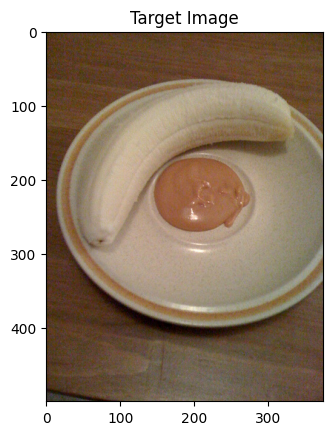

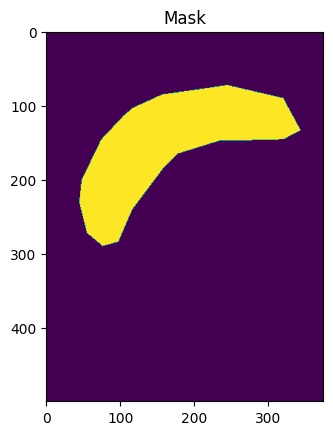

In [7]:
#load main image, annotations and mask
img1_filename = random.choice(os.listdir(database_path)) #pick randomly or select a filename
# img_filenames = os.listdir(database_path)
# img1_filename = "000000578792.jpg"
img1, info_img1, mask_img1 = load_image_and_annotations(img1_filename, database_path)
img1_h, img1_w, img1_chann = img1.shape

img2 = img1.copy()

plt.figure()
plt.imshow(img2[:,:,::-1])
plt.title("Target Image")

plt.figure()
plt.imshow(mask_img1[0])
plt.title("Mask")

print("Target image: ",img1_filename)


(500, 375, 3)
warped_img_list 1
NEW  500 W  375
OLD  500 W  375
OLD AFTER CROP  500 W  375
(500, 375)
warped_img_list 1
NEW  500 W  375
OLD  500 W  375
OLD AFTER CROP  500 W  375


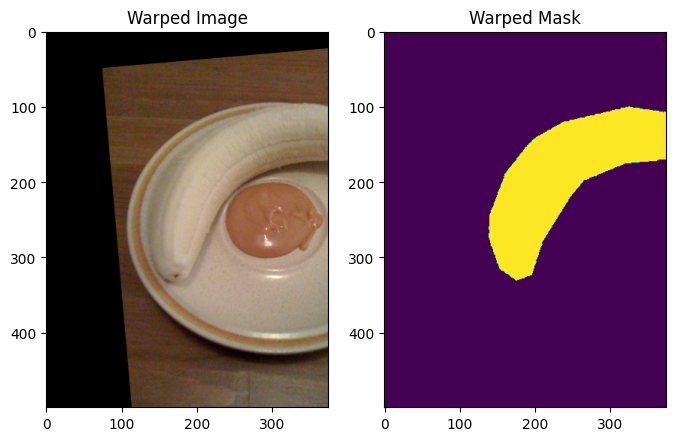

tensor([60, 54])
Boxes(tensor([[  4.0669,   5.9932, 375.0000, 492.8683],
        [146.8399, 173.3023, 273.4949, 273.9646]]))
tensor([46, 60, 45])
Boxes(tensor([[111.1158,  79.2638, 366.9852, 332.4561],
        [  0.0000,  53.1953, 375.0000, 500.0000],
        [ 15.6391,  55.3169, 373.1885, 410.7177]]))
tensor([60, 41])
Boxes(tensor([[ 51.5509,  18.8457, 374.8473, 472.1138],
        [106.9404, 101.9405, 375.0000, 424.0169]]))
PIoU - New image and Original image:
Number of annotations for image 1: 3
Number of annotations for image 2: 2
DIFFERENT CLASS PREDICTED. Piou_13 for object 1: Annotation=[111.11582  79.26383 366.98523 332.4561 ], Class=46, Piou=0.1934303693447255, Max_iou=0.358720064163208, Matching object: Annotation=[  4.066944    5.9931717 375.        492.86832  ], Class=60
Piou_13 for object 2: Annotation=[  0.        53.195255 375.       500.      ], Class=60, Piou=0.8530857186541003, Max_iou=0.8812748789787292, Matching object: Annotation=[  4.066944    5.9931717 375.       

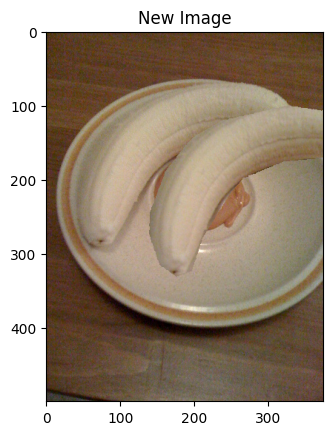

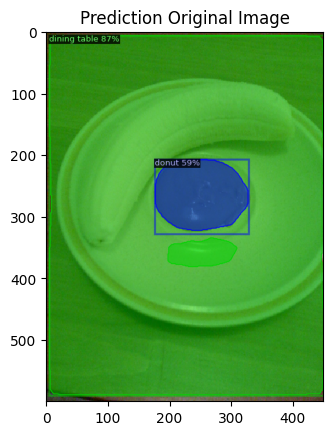

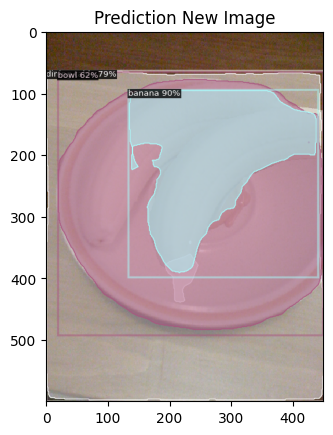

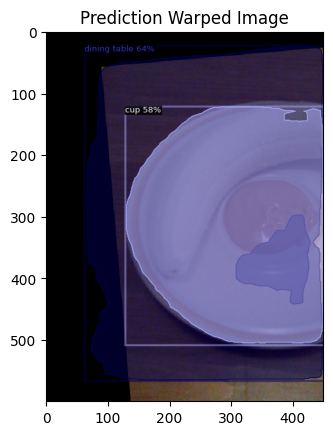

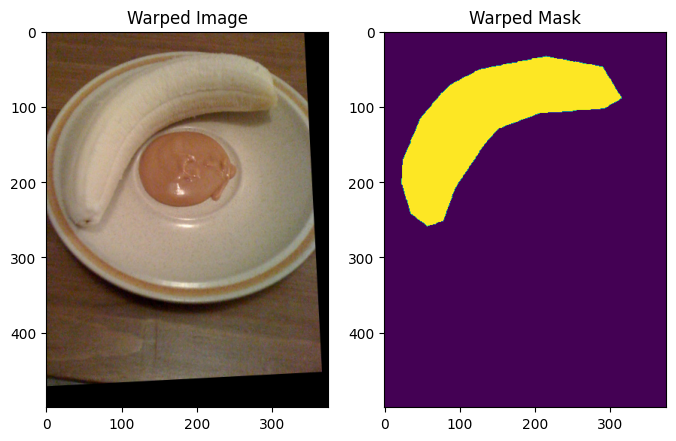

tensor([60, 54])
Boxes(tensor([[  4.0669,   5.9932, 375.0000, 492.8683],
        [146.8399, 173.3023, 273.4949, 273.9646]]))
tensor([46, 60])
Boxes(tensor([[ 22.4046,  36.7133, 338.0880, 309.1292],
        [  0.0000,   0.0000, 373.9028, 493.8318]]))
tensor([60])
Boxes(tensor([[  0.0000,   5.6412, 361.7305, 464.1449]]))
PIoU - New image and Original image:
Number of annotations for image 1: 2
Number of annotations for image 2: 2
DIFFERENT CLASS PREDICTED. Piou_13 for object 1: Annotation=[ 22.404642  36.713318 338.088    309.1292  ], Class=46, Piou=0.2511325541360877, Max_iou=0.47617989778518677, Matching object: Annotation=[  4.066944    5.9931717 375.        492.86832  ], Class=60
Piou_13 for object 2: Annotation=[  0.        0.      373.90277 493.83185], Class=60, Piou=0.939050016416767, Max_iou=0.972375750541687, Matching object: Annotation=[  4.066944    5.9931717 375.        492.86832  ], Class=60
PIoU - New image and Warped image:
Number of annotations for image 1: 2
Number of an

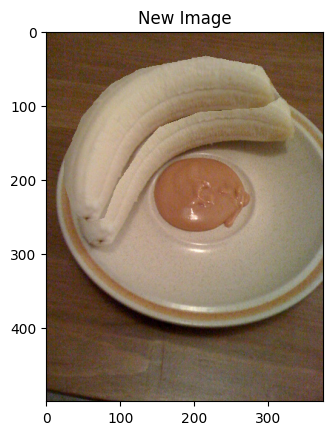

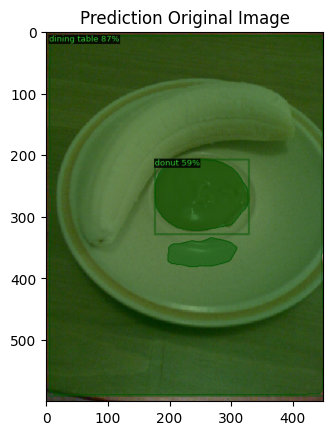

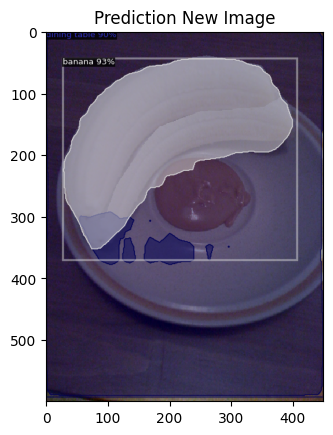

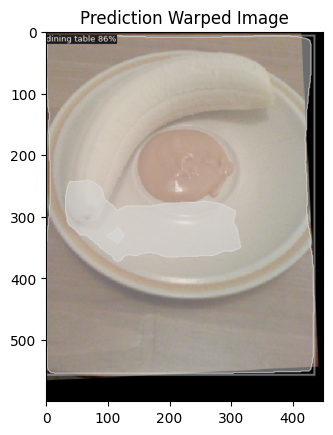

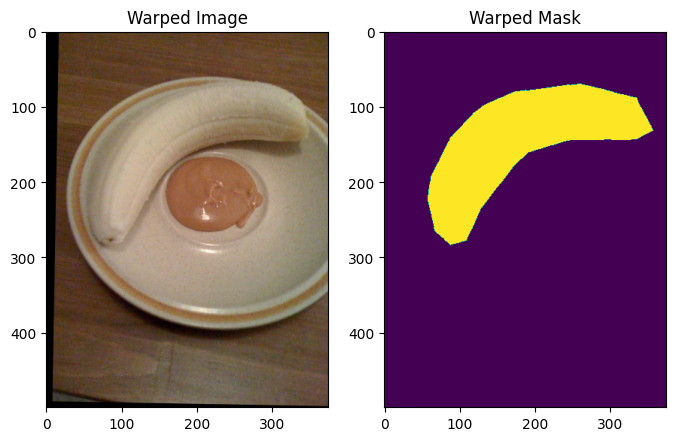

tensor([60, 54])
Boxes(tensor([[  4.0669,   5.9932, 375.0000, 492.8683],
        [146.8399, 173.3023, 273.4949, 273.9646]]))
tensor([60, 54])
Boxes(tensor([[1.6980e-01, 3.2071e+00, 3.7500e+02, 4.9009e+02],
        [1.4700e+02, 1.7329e+02, 2.7395e+02, 2.7312e+02]]))
tensor([60, 54])
Boxes(tensor([[  2.4133,  14.1234, 374.2833, 491.4855],
        [159.1943, 169.9250, 286.3322, 271.1212]]))
PIoU - New image and Original image:
Number of annotations for image 1: 2
Number of annotations for image 2: 2
Piou_13 for object 1: Annotation=[1.6980171e-01 3.2071199e+00 3.7500000e+02 4.9009097e+02], Class=60, Piou=0.963621207069023, Max_iou=0.9784170389175415, Matching object: Annotation=[  4.066944    5.9931717 375.        492.86832  ], Class=60
Piou_13 for object 2: Annotation=[146.99767 173.29362 273.9469  273.1229 ], Class=54, Piou=0.9701373681067091, Max_iou=0.9868252873420715, Matching object: Annotation=[146.83994 173.30232 273.4949  273.96463], Class=54
PIoU - New image and Warped image:
Nu

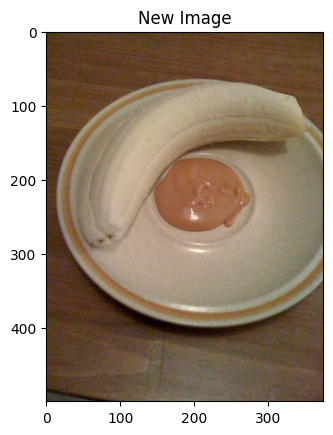

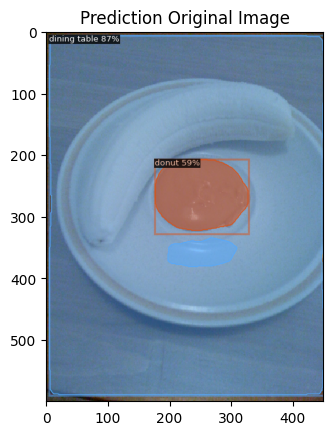

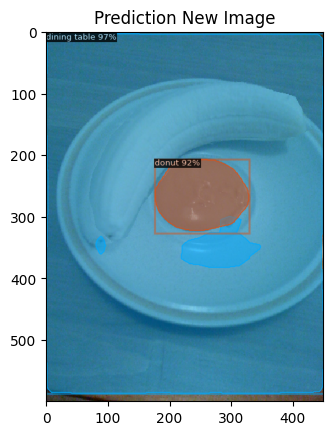

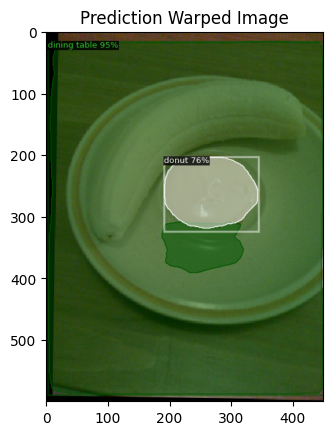

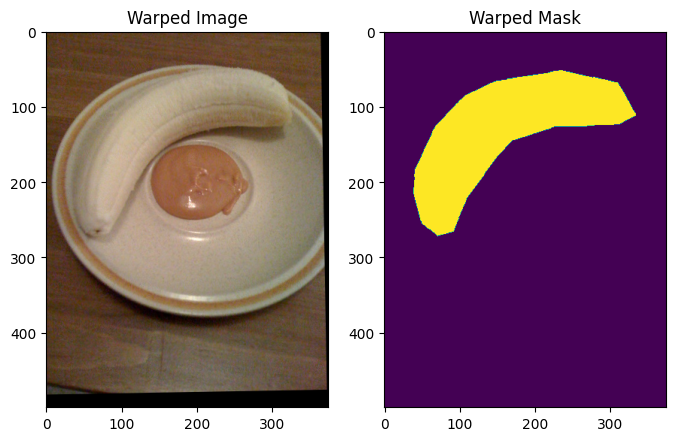

tensor([60, 54])
Boxes(tensor([[  4.0669,   5.9932, 375.0000, 492.8683],
        [146.8399, 173.3023, 273.4949, 273.9646]]))
tensor([60, 54])
Boxes(tensor([[  0.0000,   0.0000, 374.6732, 489.3804],
        [146.1471, 173.1820, 274.1481, 273.7761]]))
tensor([60])
Boxes(tensor([[  0.0000,   8.6894, 370.1431, 477.2419]]))
PIoU - New image and Original image:
Number of annotations for image 1: 2
Number of annotations for image 2: 2
Piou_13 for object 1: Annotation=[  0.        0.      374.67322 489.3804 ], Class=60, Piou=0.9008294625082947, Max_iou=0.9693569540977478, Matching object: Annotation=[  4.066944    5.9931717 375.        492.86832  ], Class=60
Piou_13 for object 2: Annotation=[146.14714 173.182   274.14813 273.77606], Class=54, Piou=0.9905669744811836, Max_iou=0.9864710569381714, Matching object: Annotation=[146.83994 173.30232 273.4949  273.96463], Class=54
PIoU - New image and Warped image:
Number of annotations for image 1: 2
Number of annotations for image 2: 1
Piou_13 for o

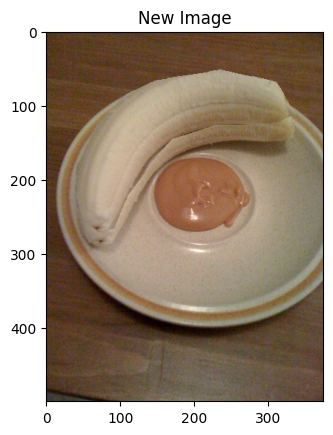

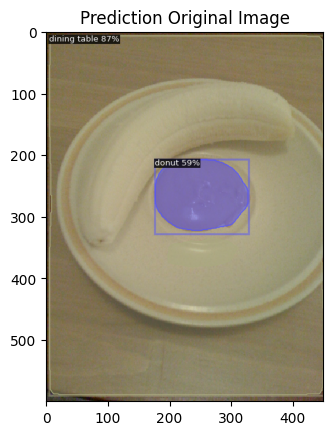

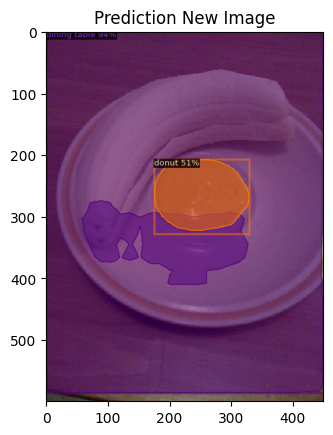

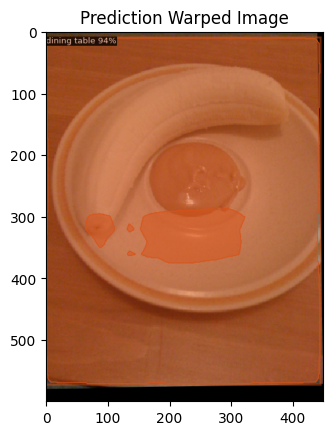

In [8]:
for i in range(4):
    tx = random.randint(-1000, 1000) # generate a random translation in the x direction
    ty = random.randint(-1000, 1000) # generate a random translation in the y direction
    rotation_angle_deg = random.randint(-5, 5) # generate a random rotation angle
    new_image_height, new_image_width = img1_h, img1_w
    
    # apply the transformation to the image
    warped_image = apply_transformation([img2], tx, ty, rotation_angle_deg)  
    warped_image = pad_images(warped_image, img1_h, img1_w)
    warped_image = np.array(warped_image)[0]
    
    img2_h, img2_w = warped_image.shape[:2]

    # apply the transformation to the mask
    warped_mask_list = apply_transformation([mask_img1[0]], tx, ty, rotation_angle_deg)  
    warped_mask = pad_images(warped_mask_list, img1_h, img1_w)
    warped_mask = np.array(warped_mask)[0]

    # display the warped image and warped mask
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(warped_image[:, :, ::-1])
    plt.title("Warped Image")
    plt.subplot(1, 2, 2)
    plt.imshow(warped_mask)
    plt.title("Warped Mask")
    plt.show()
    plt.close()
    
    # display the new image after transplanting an object from the image into another location in the same image 
    new_image = transplant_images(img1,warped_image,warped_mask)
    plt.figure()
    plt.imshow(new_image[:, :, ::-1])
    plt.title("New Image")
    
    # display the output images with the predictions
    output_image_1, _ = predict(predictor, img1)
    plt.figure()
    plt.imshow(output_image_1)
    plt.title("Prediction Original Image")

    output_new_image, _ = predict(predictor,new_image)
    plt.figure()
    plt.imshow(output_new_image)
    plt.title("Prediction New Image")

    output_warped_image, _ = predict(predictor,warped_image)
    plt.figure()
    plt.imshow(output_warped_image)
    plt.title("Prediction Warped Image")


    print ('PIoU - New image and Original image:')
    pious1_list = compute_piou(new_image,img1,predictor)
    print ('PIoU - New image and Warped image:')
    pious2_list = compute_piou(new_image,warped_image,predictor)
